# Homework 6: CIFAR-10 Classification



## 2.1 Prepare the Dataset

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow_datasets as tfds
import tensorflow as tf
tf.random.set_seed(0)
from tensorflow import keras
import numpy as np
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import datetime

train, test = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incomplete36HLPN/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incomplete36HLPN/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
for input, target in train.take(1):
  print(input.shape, target)
  shape_img = input.shape


(32, 32, 3) tf.Tensor(7, shape=(), dtype=int64)


In [ ]:
# Size of Data:
print(f"Total number of train images: {len(train)} & Total number of test images: {len(test)} ")
print(f"Size of an image is {shape_img[0]} X {shape_img[1]} and has color channels {shape_img[2]}, that means it is colored image")

Total number of train images: 50000 & Total number of test images: 10000 
Size of an image is 32 X 32 and has color channels 3, that means it is colored image


- Preprocessing function

In [ ]:
def augment(image, label):
  tf.random.set_seed(0)
  image = tf.image.random_crop(image, size=[32, 32, 3])
  image = tf.image.random_brightness(image, max_delta=0.5)
#   image = tf.image.random_flip_left_right(image)
#   image = tf.image.random_flip_up_down(image)
  return image, label

def prepare_cifar_data(cifar, batch_size, augmentation=False):
  tf.random.set_seed(0)
  #convert data from uint8 to float32
  cifar = cifar.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #normalize image values
  cifar = cifar.map(lambda img, target: ((img/128.)-1., target))
  #create one-hot targets
  cifar = cifar.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  cifar = cifar.cache()
  #shuffle, batch, prefetch
  cifar = cifar.shuffle(1000)

  if augmentation == True:
    cifar = cifar.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #cifar = cifar.map(lambda x,y: )
    # return
  cifar = cifar.batch(int(batch_size))
  cifar = cifar.prefetch(20)

  return cifar

# def prepare_cifar_data(cifar, batch_size, augmentation=False):
#   tf.random.set_seed(0)
#   #convert data from uint8 to float32
#   cifar = cifar.map(lambda img, target: (tf.cast(img, tf.float32), target))
#   #normalize image values
#   cifar = cifar.map(lambda img, target: ((img/128.)-1., target))
#   #create one-hot targets
#   cifar = cifar.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
#   #cache this progress in memory, as there is no need to redo it; it is deterministic after all
#   cifar = cifar.cache()
#   #shuffle, batch, prefetch
#   cifar = cifar.shuffle(1000)
#   cifar = cifar.batch(int(batch_size))
#   cifar = cifar.prefetch(20)

#   if augmentation == True:
#     #cifar = cifar.map(lambda x,y: )
#     return

#   #return preprocessed dataset
#   return cifar

# #train_ds = prepare_cifar_data(train, 32)
# #test_ds = prepare_cifar_data(test, 32)

## 2.2 Optimise your Model

# Base Model

In [ ]:
class BasicConv(tf.keras.Model):
    def __init__(self, optimizer,learning_rate):
        super(BasicConv, self).__init__()
        tf.random.set_seed(0)

        ''' don't know why, but this doesn't work for us...
        self.layer_list = [tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu'),
                           tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu'),
                           tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
                           tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu'),
                           tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu'),
                           tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
                           tf.keras.layers.Conv2D(filters=72, kernel_size=3, padding='same', activation='relu'),
                           tf.keras.layers.Conv2D(filters=72, kernel_size=3, padding='same', activation='relu'),
                           tf.keras.layers.GlobalAvgPool2D(),
                           tf.keras.layers.Dense(10, activation='softmax')]
        '''

        self.convlayer1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
        self.convlayer2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
        self.pooling1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
        self.convlayer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
        self.pooling2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer5 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')
        self.convlayer6 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')
        self.pooling3 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer7 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')
        self.convlayer8 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()

        self.out = tf.keras.layers.Dense(10, activation='softmax')
      

        #choose the intended optimizer
        if optimizer == "Adam":
          self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
        elif optimizer == "SGD+":
          self.optimizer = tf.keras.optimizers.experimental.SGD(learning_rate = learning_rate,momentum = 0.9)
        elif optimizer == "SGD":
          self.optimizer = tf.keras.optimizers.experimental.SGD(learning_rate = learning_rate)
        elif optimizer == "RMS":
          self.optimizer = tf.keras.optimizers.experimental.RMSprop(learning_rate = learning_rate)
        elif optimizer == "AdaGrad":
          self.optimizer = tf.keras.optimizers.experimental.Adagrad(learning_rate = learning_rate)

        #set metrics
        self.metrics_list = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
                             tf.keras.metrics.Mean(name="loss")]

        #set loss function
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()

    def call(self, x):
      #for layer in self.layer_list[:-1]:
      #    x = layer(x)

        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.pooling1(x)
        x = self.convlayer3(x)
        x = self.convlayer4(x)
        x = self.pooling2(x)
        x = self.convlayer5(x)
        x = self.convlayer6(x)
        x = self.pooling3(x)
        x = self.convlayer7(x)
        x = self.convlayer8(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x

    @property
    def metrics(self):
        return self.metrics_list
        # return a list with all metrics in the model to collect accuracies

    #reset all metrics objects
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    #train step method
    def train_step(self, data): 
        img, label = data
        
        with tf.GradientTape() as tape:
            output = self((img), training=True)
            loss = self.loss_function(label, output)
            
        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update the state of the metrics according to loss
        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)

        # return a dictionary with metric names as keys and metric results as values
        return {m.name : m.result() for m in self.metrics}


    # 6. test_step method
    def test_step(self, data):
        img, label = data

        # same as train step (without parameter updates)
        output = self((img), training=True)
        loss = self.loss_function(label, output)

        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)

        return {m.name : m.result() for m in self.metrics}

# Model using regularizers, either L1 or L2

In [ ]:
class BasicConvRegL(tf.keras.Model):
    def __init__(self, optimizer, regularizer,learning_rate):
        super(BasicConvRegL, self).__init__()
        tf.random.set_seed(0)

        reg = None

        if regularizer == 'L1':
          regularizer = tf.keras.regularizers.L1(0.001)
        elif regularizer == 'L2':
          regularizer = tf.keras.regularizers.L2(0.01)

        self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu', kernel_regularizer=reg)
        self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu', kernel_regularizer=reg)
        self.pooling1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu', kernel_regularizer=reg)
        self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu', kernel_regularizer=reg)
        self.pooling2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer5 = tf.keras.layers.Conv2D(filters=72, kernel_size=3, padding='same', activation='relu', kernel_regularizer=reg)
        self.convlayer6 = tf.keras.layers.Conv2D(filters=72, kernel_size=3, padding='same', activation='relu', kernel_regularizer=reg)
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()

        self.out = tf.keras.layers.Dense(10, activation='softmax')

        #choose the intended optimizer
        if optimizer == "Adam":
          self.optimizer =tf.keras.optimizers.Adam(learning_rate=learning_rate,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
        elif optimizer == "SGD+":
          self.optimizer = tf.keras.optimizers.experimental.SGD(learning_rate = learning_rate,momentum = 0.9)
        elif optimizer == "SGD":
          self.optimizer = tf.keras.optimizers.experimental.SGD(learning_rate = learning_rate)
        elif optimizer == "RMS":
          self.optimizer = tf.keras.optimizers.experimental.RMSprop(learning_rate = learning_rate)
        elif optimizer == "AdaGrad":
          self.optimizer = tf.keras.optimizers.experimental.Adagrad(learning_rate = learning_rate)

        #set metrics
        self.metrics_list = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
                             tf.keras.metrics.Mean(name="loss")]

        #set loss function
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()

    def call(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.pooling1(x)
        x = self.convlayer3(x)
        x = self.convlayer4(x)
        x = self.pooling2(x)
        x = self.convlayer5(x)
        x = self.convlayer6(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x

    @property
    def metrics(self):
        return self.metrics_list
        # return a list with all metrics in the model to collect accuracies

    #reset all metrics objects
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    #train step method
    def train_step(self, data): 
        img, label = data
        
        with tf.GradientTape() as tape:
            output = self((img), training=True)
            loss = self.loss_function(label, output)
            
        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update the state of the metrics according to loss
        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)

        # return a dictionary with metric names as keys and metric results as values
        return {m.name : m.result() for m in self.metrics}


    # 6. test_step method
    def test_step(self, data):
        img, label = data

        # same as train step (without parameter updates)
        output = self((img), training=True)
        loss = self.loss_function(label, output)

        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)

        return {m.name : m.result() for m in self.metrics}

# Model using dropout

In [ ]:
class BasicConvDrop(tf.keras.Model):
    def __init__(self, optimizer, dropout_rate,learning_rate):
        super(BasicConvDrop, self).__init__()
        tf.random.set_seed(0)

        self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.dropout_layer1 = tf.keras.layers.Dropout(dropout_rate)
  
        self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.dropout_layer2 = tf.keras.layers.Dropout(dropout_rate)
        self.pooling1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.dropout_layer3 = tf.keras.layers.Dropout(dropout_rate)
        self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.dropout_layer4 = tf.keras.layers.Dropout(dropout_rate)
        self.pooling2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer5 = tf.keras.layers.Conv2D(filters=72, kernel_size=3, padding='same', activation='relu')
        self.dropout_layer5 = tf.keras.layers.Dropout(dropout_rate)
        self.convlayer6 = tf.keras.layers.Conv2D(filters=72, kernel_size=3, padding='same', activation='relu')
        self.dropout_layer6 = tf.keras.layers.Dropout(dropout_rate)
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()

        self.out = tf.keras.layers.Dense(10, activation='softmax')

        #choose the intended optimizer
        if optimizer == "Adam":
          self.optimizer =tf.keras.optimizers.Adam(learning_rate=learning_rate,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
        elif optimizer == "SGD+":
          self.optimizer = tf.keras.optimizers.experimental.SGD(learning_rate = learning_rate,momentum = 0.9)
        elif optimizer == "SGD":
          self.optimizer = tf.keras.optimizers.experimental.SGD(learning_rate = learning_rate)
        elif optimizer == "RMS":
          self.optimizer = tf.keras.optimizers.experimental.RMSprop(learning_rate = learning_rate)
        elif optimizer == "AdaGrad":
          self.optimizer = tf.keras.optimizers.experimental.Adagrad(learning_rate = learning_rate)

        #set metrics
        self.metrics_list = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
                             tf.keras.metrics.Mean(name="loss")]

        #set loss function
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()

    def call(self, x):
        x = self.convlayer1(x)
        x = self.dropout_layer1(x)
        x = self.convlayer2(x)
        x = self.dropout_layer2(x)
        x = self.pooling1(x)
        x = self.convlayer3(x)
        x = self.dropout_layer3(x)
        x = self.convlayer4(x)
        x = self.dropout_layer4(x)
        x = self.pooling2(x)
        x = self.convlayer5(x)
        x = self.dropout_layer5(x)
        x = self.convlayer6(x)
        x = self.dropout_layer6(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x

    @property
    def metrics(self):
        return self.metrics_list
        # return a list with all metrics in the model to collect accuracies

    #reset all metrics objects
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    #train step method
    def train_step(self, data): 
        img, label = data
        
        with tf.GradientTape() as tape:
            output = self((img), training=True)
            loss = self.loss_function(label, output)
            
        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update the state of the metrics according to loss
        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)

        # return a dictionary with metric names as keys and metric results as values
        return {m.name : m.result() for m in self.metrics}


    # 6. test_step method
    def test_step(self, data):
        img, label = data

        # same as train step (without parameter updates)
        output = self((img), training=True)
        loss = self.loss_function(label, output)

        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)

        return {m.name : m.result() for m in self.metrics}

# Model using BatchNormalization

In [ ]:
class BasicConvBatch(tf.keras.Model):
    def __init__(self, optimizer,learning_rate):
        super(BasicConvBatch, self).__init__()
        tf.random.set_seed(0)

        self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.convlayer3 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.batch_norm3 = tf.keras.layers.BatchNormalization()
        self.pooling1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.batch_norm4 = tf.keras.layers.BatchNormalization()
        self.convlayer5 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.batch_norm5 = tf.keras.layers.BatchNormalization()
        self.convlayer6 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.batch_norm6 = tf.keras.layers.BatchNormalization()
        self.pooling2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer7 = tf.keras.layers.Conv2D(filters=72, kernel_size=3, padding='same', activation='relu')
        self.batch_norm7 = tf.keras.layers.BatchNormalization()
        self.convlayer8 = tf.keras.layers.Conv2D(filters=72, kernel_size=3, padding='same', activation='relu')
        self.batch_norm8 = tf.keras.layers.BatchNormalization()
        self.convlayer9 = tf.keras.layers.Conv2D(filters=72, kernel_size=3, padding='same', activation='relu')
        self.batch_norm9 = tf.keras.layers.BatchNormalization()
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()

        self.out = tf.keras.layers.Dense(10, activation='softmax')
      

        #choose the intended optimizer
        if optimizer == "Adam":
          self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
        elif optimizer == "SGD+":
          self.optimizer = tf.keras.optimizers.experimental.SGD(learning_rate = learning_rate,momentum = 0.9)
        elif optimizer == "SGD":
          self.optimizer = tf.keras.optimizers.experimental.SGD(learning_rate = learning_rate)
        elif optimizer == "RMS":
          self.optimizer = tf.keras.optimizers.experimental.RMSprop(learning_rate = learning_rate)
        elif optimizer == "AdaGrad":
          self.optimizer = tf.keras.optimizers.experimental.Adagrad(learning_rate = learning_rate)

        #set metrics
        self.metrics_list = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
                             tf.keras.metrics.Mean(name="loss")]

        #set loss function
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()

    def call(self, x):
      #for layer in self.layer_list[:-1]:
      #    x = layer(x)

        x = self.convlayer1(x)
        x = self.batch_norm1(x)
        x = self.convlayer2(x)
        x = self.batch_norm2(x)
        x = self.convlayer3(x)
        x = self.batch_norm3(x)
        x = self.pooling1(x)
        x = self.convlayer4(x)
        x = self.batch_norm4(x)
        x = self.convlayer5(x)
        x = self.batch_norm5(x)
        x = self.convlayer6(x)
        x = self.batch_norm6(x)
        x = self.pooling2(x)
        x = self.convlayer7(x)
        x = self.batch_norm7(x)
        x = self.convlayer8(x)
        x = self.batch_norm8(x)
        x = self.convlayer9(x)
        x = self.batch_norm9(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x

    @property
    def metrics(self):
        return self.metrics_list
        # return a list with all metrics in the model to collect accuracies

    #reset all metrics objects
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    #train step method
    def train_step(self, data): 
        img, label = data
        
        with tf.GradientTape() as tape:
            output = self((img), training=True)
            loss = self.loss_function(label, output)
            
        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update the state of the metrics according to loss
        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)

        # return a dictionary with metric names as keys and metric results as values
        return {m.name : m.result() for m in self.metrics}


    # 6. test_step method
    def test_step(self, data):
        img, label = data

        # same as train step (without parameter updates)
        output = self((img), training=True)
        loss = self.loss_function(label, output)

        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)

        return {m.name : m.result() for m in self.metrics}

# Model Dropout and Batch Normalization


In [ ]:
class BasicConvBatchDrop(tf.keras.Model):
    def __init__(self, optimizer,learning_rate,dropout_rate):
        super(BasicConvBatchDrop, self).__init__()
        tf.random.set_seed(0)

        self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.dropout_layer1 = tf.keras.layers.Dropout(dropout_rate)
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.dropout_layer2 = tf.keras.layers.Dropout(dropout_rate)
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.convlayer3 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.dropout_layer3 = tf.keras.layers.Dropout(dropout_rate)
        self.batch_norm3 = tf.keras.layers.BatchNormalization()
        self.pooling1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.dropout_layer4 = tf.keras.layers.Dropout(dropout_rate)
        self.batch_norm4 = tf.keras.layers.BatchNormalization()
        self.convlayer5 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.dropout_layer5 = tf.keras.layers.Dropout(dropout_rate)
        self.batch_norm5 = tf.keras.layers.BatchNormalization()
        self.convlayer6 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.dropout_layer6 = tf.keras.layers.Dropout(dropout_rate)
        self.batch_norm6 = tf.keras.layers.BatchNormalization()
        self.pooling2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer7 = tf.keras.layers.Conv2D(filters=72, kernel_size=3, padding='same', activation='relu')
        self.dropout_layer7 = tf.keras.layers.Dropout(dropout_rate)
        self.batch_norm7 = tf.keras.layers.BatchNormalization()
        self.convlayer8 = tf.keras.layers.Conv2D(filters=72, kernel_size=3, padding='same', activation='relu')
        self.dropout_layer8 = tf.keras.layers.Dropout(dropout_rate)
        self.batch_norm8 = tf.keras.layers.BatchNormalization()
        self.convlayer9 = tf.keras.layers.Conv2D(filters=72, kernel_size=3, padding='same', activation='relu')
        self.dropout_layer9 = tf.keras.layers.Dropout(dropout_rate)
        self.batch_norm9 = tf.keras.layers.BatchNormalization()
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()

        self.out = tf.keras.layers.Dense(10, activation='softmax')
      

        #choose the intended optimizer
        if optimizer == "Adam":
          self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
        elif optimizer == "SGD+":
          self.optimizer = tf.keras.optimizers.experimental.SGD(learning_rate = learning_rate,momentum = 0.9)
        elif optimizer == "SGD":
          self.optimizer = tf.keras.optimizers.experimental.SGD(learning_rate = learning_rate)
        elif optimizer == "RMS":
          self.optimizer = tf.keras.optimizers.experimental.RMSprop(learning_rate = learning_rate)
        elif optimizer == "AdaGrad":
          self.optimizer = tf.keras.optimizers.experimental.Adagrad(learning_rate = learning_rate)

        #set metrics
        self.metrics_list = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
                             tf.keras.metrics.Mean(name="loss")]

        #set loss function
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()

    def call(self, x):
      #for layer in self.layer_list[:-1]:
      #    x = layer(x)

        x = self.convlayer1(x)
        x = self.dropout_layer1(x)
        x = self.batch_norm1(x)
        x = self.convlayer2(x)
        x = self.dropout_layer2(x)
        x = self.batch_norm2(x)
        x = self.convlayer3(x)
        x = self.dropout_layer3(x)
        x = self.batch_norm3(x)
        x = self.pooling1(x)
        x = self.convlayer4(x)
        x = self.dropout_layer4(x)
        x = self.batch_norm4(x)
        x = self.convlayer5(x)
        x = self.dropout_layer5(x)
        x = self.batch_norm5(x)
        x = self.convlayer6(x)
        x = self.dropout_layer6(x)
        x = self.batch_norm6(x)
        x = self.pooling2(x)
        x = self.convlayer7(x)
        x = self.dropout_layer7(x)
        x = self.batch_norm7(x)
        x = self.convlayer8(x)
        x = self.dropout_layer8(x)
        x = self.batch_norm8(x)
        x = self.convlayer9(x)
        x = self.dropout_layer9(x)
        x = self.batch_norm9(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x

    @property
    def metrics(self):
        return self.metrics_list
        # return a list with all metrics in the model to collect accuracies

    #reset all metrics objects
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    #train step method
    def train_step(self, data): 
        img, label = data
        
        with tf.GradientTape() as tape:
            output = self((img), training=True)
            loss = self.loss_function(label, output)
            
        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update the state of the metrics according to loss
        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)

        # return a dictionary with metric names as keys and metric results as values
        return {m.name : m.result() for m in self.metrics}


    # 6. test_step method
    def test_step(self, data):
        img, label = data

        # same as train step (without parameter updates)
        output = self((img), training=True)
        loss = self.loss_function(label, output)

        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)

        return {m.name : m.result() for m in self.metrics}

Summary writer


In [ ]:
def create_summary_writers(config_name):
    tf.random.set_seed(0)
    
    # Define where to save the logs
    
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    train_log_path = f"logs/{config_name}/{current_time}/training"
    val_log_path = f"logs/{config_name}/{current_time}/test"

    # log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)

    # log writer for validation metrics
    val_summary_writer = tf.summary.create_file_writer(val_log_path)
    
    return train_summary_writer, val_summary_writer

Visualization 

In [ ]:
def result_visualization(train_losses, train_accuracies, test_losses, test_accuracies, config = "for Basic Model"):
  # plot loss  
  plt.figure(figsize=(10,8))
  plt.subplot(211)
  plt.title('Loss: ' + config + ' with Augmentations')
  plt.plot(train_losses, color='blue', label='train')
  plt.plot(test_losses, color='orange', label='test')
  plt.legend(loc="best")
  # plot accuracy
  plt.subplot(212)
  plt.title('Accuracy: ' + config + ' with Augmentations')
  plt.plot(train_accuracies, color='blue', label='train')
  plt.plot(test_accuracies, color='orange', label='test')
  plt.legend(loc="best")

# Training Definition

In [ ]:

def training_function(optimizer, regularizer= "No_Regularization",epochs = 15, dropout_rate = 0.5, learning_rate = 0.001,batch_size = 32,plot = True,augmentation=True):
  train_summary_writer, val_summary_writer = create_summary_writers(config_name = str(optimizer))

  prep_train_ds = prepare_cifar_data(train, batch_size,augmentation=True)
  if augmentation:
      prep_train_ds_aug = prepare_cifar_data(train, batch_size,augmentation=True)
      prep_train_ds = prep_train_ds.concatenate(prep_train_ds_aug)

  # Augmentation is performed only on train dataset
  prep_test_ds = prepare_cifar_data(test, batch_size,augmentation = False)

  if (regularizer == "L1" or regularizer == "L2"):
    model = BasicConvRegL(optimizer, regularizer, learning_rate)
  elif (regularizer == "dropout"):
    model = BasicConvDrop(optimizer,dropout_rate,learning_rate)
  elif (regularizer == "batch_norm"):
    model = BasicConvBatch(optimizer,learning_rate)
  elif (regularizer == "batch_norm_dropout"):
    model = BasicConvBatchDrop(optimizer,dropout_rate,learning_rate)
  else:
    model = BasicConv(optimizer,learning_rate)

  model,train_losses, train_accuracies, test_losses, test_accuracies = training_loop(model, prep_train_ds, prep_test_ds, epochs, train_summary_writer, val_summary_writer)
  #return train_losses, train_accuracies, test_losses, test_accuracies
  if plot:
    result_visualization(train_losses, train_accuracies, test_losses, test_accuracies,config =optimizer +" "+ regularizer )
  return model

#pass a model to it that is supposed to be trained
#def training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer, save_path):
def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, val_summary_writer):
  tf.random.set_seed(0)
  train_accuracies = []
  train_losses = []
  test_accuracies = []
  test_losses = []
  #1. iterate over epochs
  for e in range(epochs):
    print(f'Epoch: {str(e)}')

    #2. train steps on all batches in the traning dataset
    for data in train_ds:
      metrics = model.train_step(data)

    # 3. log and print training metrics
    with train_summary_writer.as_default():
      # for scalar metrics:
      for metric in model.metrics:
        tf.summary.scalar(f"{metric.name}", metric.result(), step=e)

    print([f"train_{key}: {round(value.numpy(),3)}" for (key, value) in metrics.items()])
    for k, v in metrics.items():
      if "accuracy" in k:
        train_accuracies.append(round(v.numpy(),3))
      elif "loss" in k:
        train_losses.append(round(v.numpy(),3))

    #4. reset metrics object
    model.reset_metrics()

    #5. evaluate on valdation data
    for test_data in test_ds:
      metrics_test = model.test_step(test_data)

    # 6. log validation metrics

    with val_summary_writer.as_default():
      # for scalar metrics:
        for metric in model.metrics:
          tf.summary.scalar(f"{metric.name}", metric.result(), step=e)

    print([f"test_{key}: {round(value.numpy(),3)}" for (key, value) in metrics_test.items()])
    
    for k, v in metrics_test.items():
      if "accuracy" in k:
        test_accuracies.append(round(v.numpy(),3))
      elif "loss" in k:
        test_losses.append(round(v.numpy(),3))
    
    print("\n")

  return model,train_losses, train_accuracies, test_losses, test_accuracies

# Applying Models

# Optimizer: SGD

1. Basic Convolution Network: As Expected Model has really low accuracy and over the epochs the accuracy doesn't improve much
2. L1 Regularization: With L1 Regularization we see a slight improvemnt in accuracy.
3. L2 Regularization: With L2 Regularization we see a slight improvemnt in accuracy.
4. Dropout Regularization: With Dropout Regularization we see model is trained faster and accuracy is also better.
5. Applying Batch Normalization: With Batch Normalization we see the accuracy has improved further.
6. Batch Normalization with Drop Out: We start to see better accuracy from the beginning itself and it reaches to a high value. Also we see that model suffers from overfitting at the end.


Epoch: 0


['train_accuracy: 0.10000000149011612', 'train_loss: 2.302999973297119']
['test_accuracy: 0.10000000149011612', 'test_loss: 2.302000045776367']


Epoch: 1
['train_accuracy: 0.10000000149011612', 'train_loss: 2.302000045776367']
['test_accuracy: 0.10000000149011612', 'test_loss: 2.302000045776367']


Epoch: 2
['train_accuracy: 0.10000000149011612', 'train_loss: 2.302000045776367']
['test_accuracy: 0.10400000214576721', 'test_loss: 2.302000045776367']


Epoch: 3
['train_accuracy: 0.10599999874830246', 'train_loss: 2.302000045776367']
['test_accuracy: 0.11800000071525574', 'test_loss: 2.3010001182556152']


Epoch: 4
['train_accuracy: 0.12700000405311584', 'train_loss: 2.3010001182556152']
['test_accuracy: 0.1420000046491623', 'test_loss: 2.3010001182556152']


Epoch: 5
['train_accuracy: 0.1509999930858612', 'train_loss: 2.3010001182556152']
['test_accuracy: 0.15700000524520874', 'test_loss: 2.3010001182556152']


Epoch: 6
['train_accuracy: 0.16500000655651093', 'train_loss: 2.299999952316

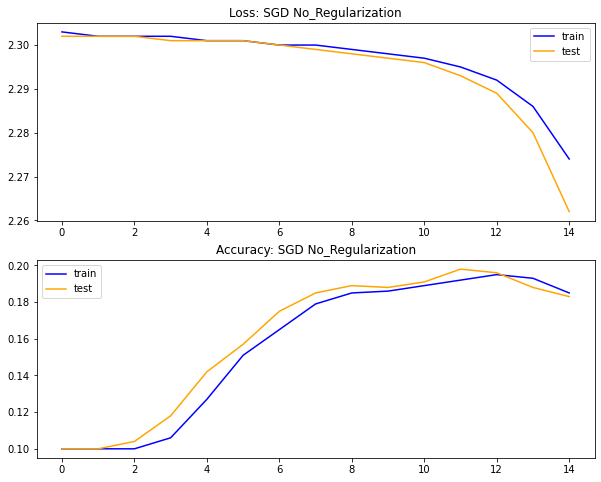

In [ ]:
!rm -rf logs/
# 1. Basic Convolution Network: Training with classic SGD optimizer (without momentum)
model = training_function(optimizer = "SGD",epochs=15, learning_rate = 0.001,batch_size = 64)

Epoch: 0
['train_accuracy: 0.11299999803304672', 'train_loss: 2.302000045776367']
['test_accuracy: 0.11299999803304672', 'test_loss: 2.302000045776367']


Epoch: 1
['train_accuracy: 0.11400000005960464', 'train_loss: 2.302000045776367']
['test_accuracy: 0.1120000034570694', 'test_loss: 2.302000045776367']


Epoch: 2
['train_accuracy: 0.10999999940395355', 'train_loss: 2.3010001182556152']
['test_accuracy: 0.10599999874830246', 'test_loss: 2.3010001182556152']


Epoch: 3
['train_accuracy: 0.10899999737739563', 'train_loss: 2.3010001182556152']
['test_accuracy: 0.11500000208616257', 'test_loss: 2.299999952316284']


Epoch: 4
['train_accuracy: 0.11999999731779099', 'train_loss: 2.299999952316284']
['test_accuracy: 0.12399999797344208', 'test_loss: 2.2990000247955322']


Epoch: 5
['train_accuracy: 0.12600000202655792', 'train_loss: 2.2980000972747803']
['test_accuracy: 0.12800000607967377', 'test_loss: 2.296999931335449']


Epoch: 6
['train_accuracy: 0.1289999932050705', 'train_loss: 2.296

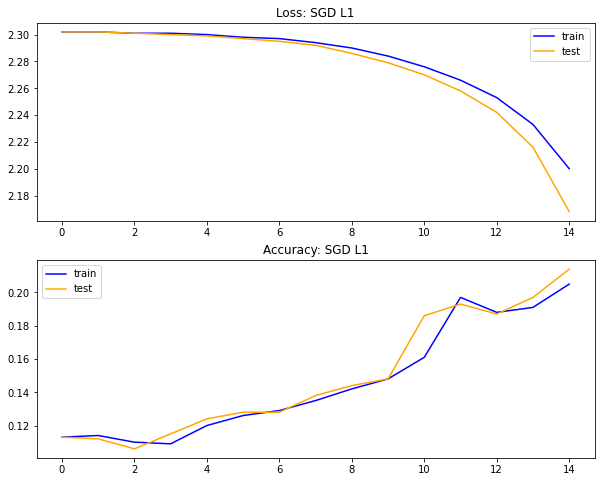

In [ ]:
!rm -rf logs/
# L1 Regularization
model = training_function(optimizer = "SGD",regularizer = "L1",epochs = 15, learning_rate = 0.001,batch_size = 64)

Epoch: 0
['train_accuracy: 0.11299999803304672', 'train_loss: 2.302000045776367']
['test_accuracy: 0.11299999803304672', 'test_loss: 2.302000045776367']


Epoch: 1
['train_accuracy: 0.11400000005960464', 'train_loss: 2.302000045776367']
['test_accuracy: 0.1120000034570694', 'test_loss: 2.302000045776367']


Epoch: 2
['train_accuracy: 0.10999999940395355', 'train_loss: 2.3010001182556152']
['test_accuracy: 0.10599999874830246', 'test_loss: 2.3010001182556152']


Epoch: 3
['train_accuracy: 0.10899999737739563', 'train_loss: 2.3010001182556152']
['test_accuracy: 0.11500000208616257', 'test_loss: 2.299999952316284']


Epoch: 4
['train_accuracy: 0.11999999731779099', 'train_loss: 2.299999952316284']
['test_accuracy: 0.12399999797344208', 'test_loss: 2.2990000247955322']


Epoch: 5
['train_accuracy: 0.12600000202655792', 'train_loss: 2.2980000972747803']
['test_accuracy: 0.12800000607967377', 'test_loss: 2.296999931335449']


Epoch: 6
['train_accuracy: 0.1289999932050705', 'train_loss: 2.296

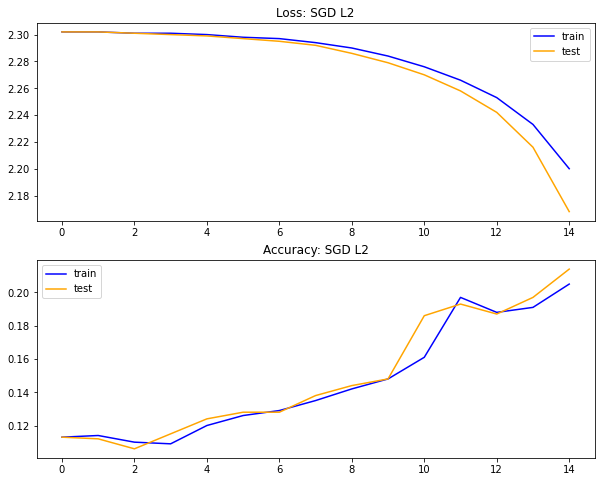

In [ ]:
!rm -rf logs/
# L2 Regularization
model = training_function(optimizer = "SGD",regularizer = "L2",epochs = 15,  learning_rate = 0.001,batch_size = 64)

Epoch: 0
['train_accuracy: 0.2849999964237213', 'train_loss: 1.9390000104904175']
['test_accuracy: 0.35499998927116394', 'test_loss: 1.7510000467300415']


Epoch: 1
['train_accuracy: 0.38100001215934753', 'train_loss: 1.6920000314712524']
['test_accuracy: 0.414000004529953', 'test_loss: 1.6150000095367432']


Epoch: 2
['train_accuracy: 0.4339999854564667', 'train_loss: 1.5709999799728394']
['test_accuracy: 0.4480000138282776', 'test_loss: 1.5230000019073486']


Epoch: 3
['train_accuracy: 0.4690000116825104', 'train_loss: 1.4780000448226929']
['test_accuracy: 0.47600001096725464', 'test_loss: 1.4420000314712524']


Epoch: 4
['train_accuracy: 0.49799999594688416', 'train_loss: 1.4019999504089355']
['test_accuracy: 0.49900001287460327', 'test_loss: 1.3890000581741333']


Epoch: 5
['train_accuracy: 0.5170000195503235', 'train_loss: 1.3489999771118164']
['test_accuracy: 0.5199999809265137', 'test_loss: 1.3320000171661377']


Epoch: 6
['train_accuracy: 0.5379999876022339', 'train_loss: 1.297

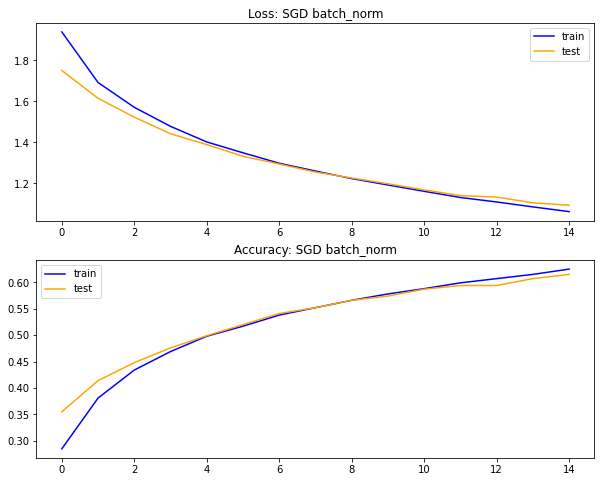

In [ ]:
!rm -rf logs/
# Applying Batch Normalization
model = training_function(optimizer = "SGD",regularizer = "batch_norm",epochs = 15, learning_rate = 0.001,batch_size = 64)

Epoch: 0
['train_accuracy: 0.5410000085830688', 'train_loss: 1.2619999647140503']
['test_accuracy: 0.6990000009536743', 'test_loss: 0.8550000190734863']


Epoch: 1
['train_accuracy: 0.7639999985694885', 'train_loss: 0.6790000200271606']
['test_accuracy: 0.7490000128746033', 'test_loss: 0.7580000162124634']


Epoch: 2
['train_accuracy: 0.8240000009536743', 'train_loss: 0.5099999904632568']
['test_accuracy: 0.7960000038146973', 'test_loss: 0.6309999823570251']


Epoch: 3
['train_accuracy: 0.8600000143051147', 'train_loss: 0.4059999883174896']
['test_accuracy: 0.7960000038146973', 'test_loss: 0.6620000004768372']


Epoch: 4
['train_accuracy: 0.8820000290870667', 'train_loss: 0.33899998664855957']
['test_accuracy: 0.8019999861717224', 'test_loss: 0.7089999914169312']


Epoch: 5
['train_accuracy: 0.9020000100135803', 'train_loss: 0.29100000858306885']
['test_accuracy: 0.8069999814033508', 'test_loss: 0.7070000171661377']


Epoch: 6
['train_accuracy: 0.9179999828338623', 'train_loss: 0.24500

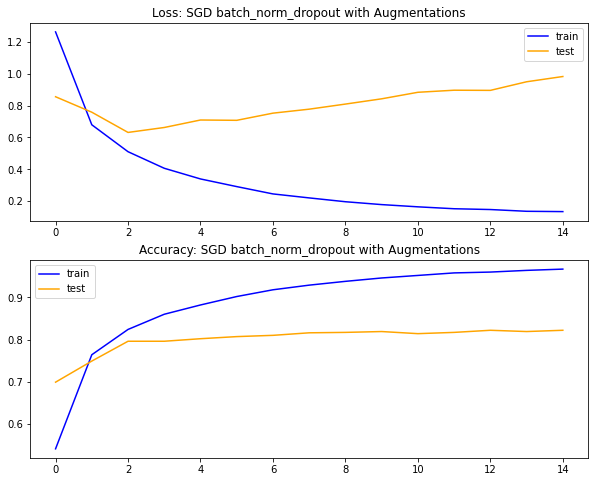

In [ ]:
!rm -rf logs/
# Applying Batch Normalization and augmentation
model = training_function(optimizer = "SGD",regularizer = "batch_norm_dropout",dropout_rate = 0.5,epochs = 15, learning_rate = 0.001,batch_size = 64)

Epoch: 0
['train_accuracy: 0.3179999887943268', 'train_loss: 1.8450000286102295']
['test_accuracy: 0.4000000059604645', 'test_loss: 1.6410000324249268']


Epoch: 1
['train_accuracy: 0.42899999022483826', 'train_loss: 1.5779999494552612']
['test_accuracy: 0.45899999141693115', 'test_loss: 1.4980000257492065']


Epoch: 2
['train_accuracy: 0.48399999737739563', 'train_loss: 1.4420000314712524']
['test_accuracy: 0.5099999904632568', 'test_loss: 1.3700000047683716']


Epoch: 3
['train_accuracy: 0.5220000147819519', 'train_loss: 1.3370000123977661']
['test_accuracy: 0.5389999747276306', 'test_loss: 1.2899999618530273']


Epoch: 4
['train_accuracy: 0.5529999732971191', 'train_loss: 1.2589999437332153']
['test_accuracy: 0.5550000071525574', 'test_loss: 1.2510000467300415']


Epoch: 5
['train_accuracy: 0.5720000267028809', 'train_loss: 1.2009999752044678']
['test_accuracy: 0.5770000219345093', 'test_loss: 1.1920000314712524']


Epoch: 6
['train_accuracy: 0.593999981880188', 'train_loss: 1.14600

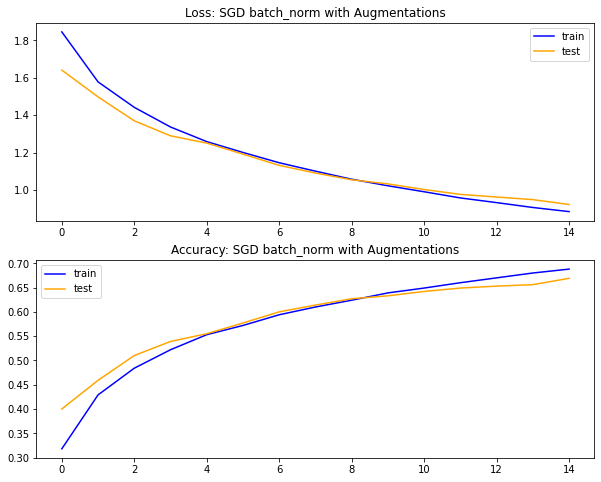

In [ ]:
!rm -rf logs/
# Applying Batch Normalization and augmentation
model = training_function(optimizer = "SGD",regularizer = "batch_norm",epochs = 15, learning_rate = 0.001,batch_size = 64)

# Optimizer: Adam

1. Basic Convolution Network: Basic Adam is far better then SGD Basic but Clearly this Model is suffering from overfitting.
2. L1 Regularization: The Model accuracy is futher improved but model still suffers from overfitting.
3. L2 Regularization: The Model accuracy is similar to L1 regularization output and model still suffers from overfitting.
4. Dropout Regularization: Model Accuracy is less than L1 and L2 Regularization but overfitting problem has resolved.
5. Applying Batch Normalization: Model Accuracy has improved but it also resulted in overfitting.
6. Batch NOrmalization with Dropout: Normalization with dropout neither help in improving accuracy nor in resolving overfitting

Epoch: 0
['train_accuracy: 0.39800000190734863', 'train_loss: 1.590000033378601']
['test_accuracy: 0.5550000071525574', 'test_loss: 1.1950000524520874']


Epoch: 1
['train_accuracy: 0.6159999966621399', 'train_loss: 1.0579999685287476']
['test_accuracy: 0.671999990940094', 'test_loss: 0.9309999942779541']


Epoch: 2
['train_accuracy: 0.7149999737739563', 'train_loss: 0.8109999895095825']
['test_accuracy: 0.7409999966621399', 'test_loss: 0.7519999742507935']


Epoch: 3
['train_accuracy: 0.7680000066757202', 'train_loss: 0.6669999957084656']
['test_accuracy: 0.7630000114440918', 'test_loss: 0.6919999718666077']


Epoch: 4
['train_accuracy: 0.8009999990463257', 'train_loss: 0.5740000009536743']
['test_accuracy: 0.7710000276565552', 'test_loss: 0.6830000281333923']


Epoch: 5
['train_accuracy: 0.8270000219345093', 'train_loss: 0.5009999871253967']
['test_accuracy: 0.7730000019073486', 'test_loss: 0.7480000257492065']


Epoch: 6
['train_accuracy: 0.8479999899864197', 'train_loss: 0.45100000

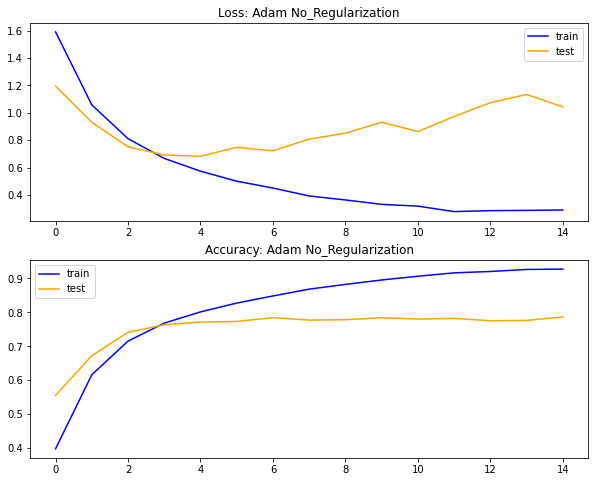

In [ ]:
!rm -rf logs/
# 1. Basic Convolution Network: Training with classic SGD optimizer (without momentum)
model = training_function(optimizer = "Adam",epochs=15, learning_rate = 0.001,batch_size = 64)

Epoch: 0
['train_accuracy: 0.3959999978542328', 'train_loss: 1.6019999980926514']
['test_accuracy: 0.5059999823570251', 'test_loss: 1.3270000219345093']


Epoch: 1
['train_accuracy: 0.5550000071525574', 'train_loss: 1.225000023841858']
['test_accuracy: 0.593999981880188', 'test_loss: 1.128000020980835']


Epoch: 2
['train_accuracy: 0.6290000081062317', 'train_loss: 1.0410000085830688']
['test_accuracy: 0.6690000295639038', 'test_loss: 0.9369999766349792']


Epoch: 3
['train_accuracy: 0.671999990940094', 'train_loss: 0.9269999861717224']
['test_accuracy: 0.6859999895095825', 'test_loss: 0.8880000114440918']


Epoch: 4
['train_accuracy: 0.703000009059906', 'train_loss: 0.8450000286102295']
['test_accuracy: 0.7059999704360962', 'test_loss: 0.8270000219345093']


Epoch: 5
['train_accuracy: 0.7289999723434448', 'train_loss: 0.7760000228881836']
['test_accuracy: 0.6970000267028809', 'test_loss: 0.8560000061988831']


Epoch: 6
['train_accuracy: 0.7450000047683716', 'train_loss: 0.728999972343

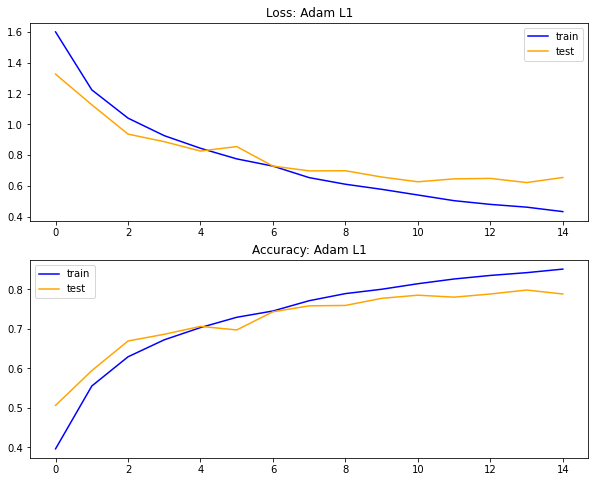

In [ ]:
!rm -rf logs/
# L1 Regularization
model = training_function(optimizer = "Adam",regularizer = "L1",epochs = 15, learning_rate = 0.001,batch_size = 64)

Epoch: 0
['train_accuracy: 0.39399999380111694', 'train_loss: 1.6130000352859497']
['test_accuracy: 0.4970000088214874', 'test_loss: 1.343999981880188']


Epoch: 1
['train_accuracy: 0.5479999780654907', 'train_loss: 1.2400000095367432']
['test_accuracy: 0.5839999914169312', 'test_loss: 1.1449999809265137']


Epoch: 2
['train_accuracy: 0.6259999871253967', 'train_loss: 1.0499999523162842']
['test_accuracy: 0.6629999876022339', 'test_loss: 0.949999988079071']


Epoch: 3
['train_accuracy: 0.6710000038146973', 'train_loss: 0.9319999814033508']
['test_accuracy: 0.6859999895095825', 'test_loss: 0.8939999938011169']


Epoch: 4
['train_accuracy: 0.7049999833106995', 'train_loss: 0.8410000205039978']
['test_accuracy: 0.7120000123977661', 'test_loss: 0.8149999976158142']


Epoch: 5
['train_accuracy: 0.7329999804496765', 'train_loss: 0.7689999938011169']
['test_accuracy: 0.7239999771118164', 'test_loss: 0.7839999794960022']


Epoch: 6
['train_accuracy: 0.7509999871253967', 'train_loss: 0.70999997

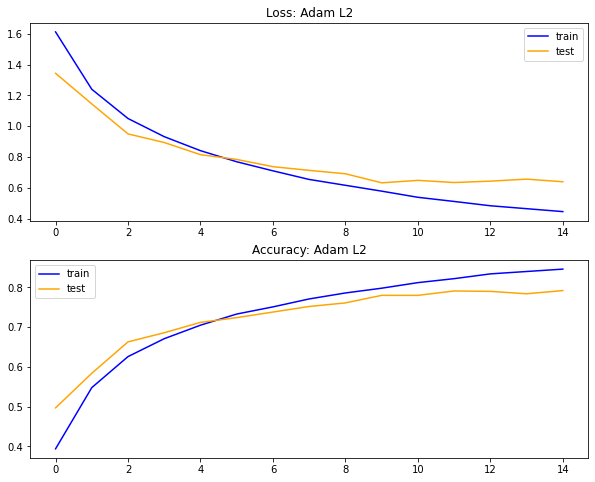

In [ ]:
!rm -rf logs/
# L1 Regularization
model = training_function(optimizer = "Adam",regularizer = "L2",epochs = 15, learning_rate = 0.001,batch_size = 64)

Epoch: 0
['train_accuracy: 0.23899999260902405', 'train_loss: 7.421000003814697']
['test_accuracy: 0.2800000011920929', 'test_loss: 1.871999979019165']


Epoch: 1
['train_accuracy: 0.3540000021457672', 'train_loss: 1.7079999446868896']
['test_accuracy: 0.4259999990463257', 'test_loss: 1.6790000200271606']


Epoch: 2
['train_accuracy: 0.36000001430511475', 'train_loss: 1.7389999628067017']
['test_accuracy: 0.4359999895095825', 'test_loss: 1.5290000438690186']


Epoch: 3
['train_accuracy: 0.41499999165534973', 'train_loss: 6.125']
['test_accuracy: 0.5099999904632568', 'test_loss: 1.340000033378601']


Epoch: 4
['train_accuracy: 0.5389999747276306', 'train_loss: 1.2799999713897705']
['test_accuracy: 0.5680000185966492', 'test_loss: 1.2369999885559082']


Epoch: 5
['train_accuracy: 0.5929999947547913', 'train_loss: 1.2289999723434448']
['test_accuracy: 0.5479999780654907', 'test_loss: 1.5529999732971191']


Epoch: 6
['train_accuracy: 0.5659999847412109', 'train_loss: 2.885999917984009']
['

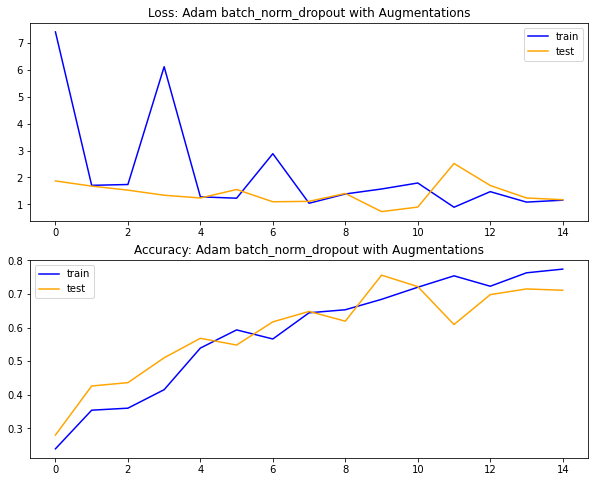

In [ ]:
!rm -rf logs
# Applying Batch Normalization
model = training_function(optimizer = "Adam",regularizer = "batch_norm_dropout",dropout_rate = 0.5,epochs = 15, learning_rate = 0.001,batch_size = 64)

Epoch: 0
['train_accuracy: 0.40299999713897705', 'train_loss: 1.6019999980926514']
['test_accuracy: 0.5249999761581421', 'test_loss: 1.305999994277954']


Epoch: 1
['train_accuracy: 0.5559999942779541', 'train_loss: 1.2239999771118164']
['test_accuracy: 0.574999988079071', 'test_loss: 1.1829999685287476']


Epoch: 2
['train_accuracy: 0.6050000190734863', 'train_loss: 1.1009999513626099']
['test_accuracy: 0.6140000224113464', 'test_loss: 1.0759999752044678']


Epoch: 3
['train_accuracy: 0.6320000290870667', 'train_loss: 1.034000039100647']
['test_accuracy: 0.6299999952316284', 'test_loss: 1.0429999828338623']


Epoch: 4
['train_accuracy: 0.6499999761581421', 'train_loss: 0.984000027179718']
['test_accuracy: 0.6470000147819519', 'test_loss: 0.9729999899864197']


Epoch: 5
['train_accuracy: 0.6660000085830688', 'train_loss: 0.9419999718666077']
['test_accuracy: 0.6679999828338623', 'test_loss: 0.9480000138282776']


Epoch: 6
['train_accuracy: 0.6790000200271606', 'train_loss: 0.9110000133

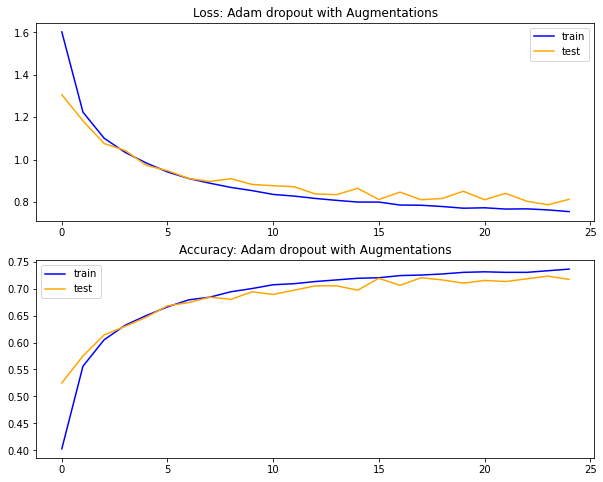

In [ ]:
!rm -rf logs
# Applying Drop out  and augmentation
model = training_function(optimizer = "Adam",regularizer = "dropout",dropout_rate = 0.5,epochs = 25, learning_rate = 0.001,batch_size = 64)

Epoch: 0
['train_accuracy: 0.6370000243186951', 'train_loss: 1.0160000324249268']
['test_accuracy: 0.7480000257492065', 'test_loss: 0.7200000286102295']


Epoch: 1
['train_accuracy: 0.7910000085830688', 'train_loss: 0.6029999852180481']
['test_accuracy: 0.7900000214576721', 'test_loss: 0.6230000257492065']


Epoch: 2
['train_accuracy: 0.8429999947547913', 'train_loss: 0.4560000002384186']
['test_accuracy: 0.7990000247955322', 'test_loss: 0.6129999756813049']


Epoch: 3
['train_accuracy: 0.8759999871253967', 'train_loss: 0.3610000014305115']
['test_accuracy: 0.8069999814033508', 'test_loss: 0.625']


Epoch: 4
['train_accuracy: 0.9010000228881836', 'train_loss: 0.28999999165534973']
['test_accuracy: 0.8090000152587891', 'test_loss: 0.6589999794960022']


Epoch: 5
['train_accuracy: 0.9169999957084656', 'train_loss: 0.24500000476837158']
['test_accuracy: 0.8050000071525574', 'test_loss: 0.7250000238418579']


Epoch: 6
['train_accuracy: 0.9300000071525574', 'train_loss: 0.21199999749660492'

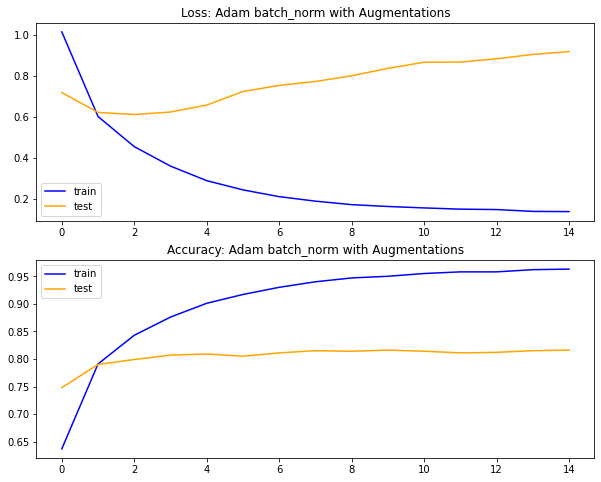

In [ ]:
!rm -rf logs
# Applying Drop out  and augmentation
model = training_function(optimizer = "Adam",regularizer = "batch_norm",epochs = 10, learning_rate = 0.0001,batch_size = 64)